THIS CODE SCALES THE TEMPLATE TO ABS MAG -19.3

In [6]:
import numpy as np
import speclite.filters

# Function to scale spectrum to given magnitude
def scale_spec(data, band, mag):
    flux, wlen = band.pad_spectrum(data['flux'], data['wav'])
    mag0 = band.get_ab_magnitude(flux, wlen)
    scale = 10 ** (-0.4 * (mag - mag0))
    #data['flux'] *= scale
    return scale

# Load Hsiao template
hsiao_file = "/home/jovyan/research/Current/hsiao_templates/snflux_1a.dat"
hsiao = np.genfromtxt(hsiao_file, names='phase, wav, flux')

# Parameters
absmag = -19.3
filter_choice = 'r'

# Select filter
filt = speclite.filters.load_filter(f'sdss2010-{filter_choice.lower()}')

mask= hsiao['phase'] == 0
scale= scale_spec(hsiao[mask],filt,absmag)
hsiao['flux'] *= scale

# Save to DAT file
scaled_templates = np.array(hsiao, dtype=[('phase', 'f8'), ('wavelength', 'f8'), ('flux', 'f8')])
np.savetxt('scaled_hsiao_templates.dat', scaled_templates, fmt='%10.5f %10.5f %10.5e', header='phase wavelength flux')

print("Saved scaled templates to scaled_hsiao_templates.dat")


Saved scaled templates to scaled_hsiao_templates.dat


THIS CODE GIVES ME THE MIN MAX OF MY REDSHIFT

In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv('diego_data.csv')

# Extract min and max values from the 'redshift' column
redshift_min = df['redshift'].min()
redshift_max = df['redshift'].max()

# Output the results
print(f"Minimum redshift: {redshift_min}")
print(f"Maximum redshift: {redshift_max}")

Minimum redshift: 0.00293
Maximum redshift: 0.35


Useful for quickly computing magnitudes at one redshift, simpler use-case scenarios.

In [8]:
import numpy as np
import speclite.filters
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u

# Function to scale spectrum to given magnitude
def scale_spec(data, band, mag):
    flux, wlen = band.pad_spectrum(data['flux'], data['wav'])
    mag0 = band.get_ab_magnitude(flux, wlen)
    scale = 10 ** (-0.4 * (mag - mag0))
    data['flux'] *= scale
    return data

# Function to redshift a spectrum
def redshift_spec(rest, z):
    flam = u.erg / u.second / u.cm**2 / u.angstrom
    llam = u.erg / u.second / u.angstrom
    flux = rest['flux'] * flam
    lum = (4 * np.pi * flux * (10 * u.pc)**2).to(llam)
    observed = rest.copy()
    observed['wav'] = rest['wav'] * (1 + z)
    slam = (1 / (1 + z)) * lum / (4 * np.pi * cosmo.luminosity_distance(z)**2)
    observed['flux'] = slam.to(flam)
    return observed

# Function to compute observed magnitudes at different phases
def compute_observed_magnitudes(scaled_template, filter_choice, redshift):
    filt = speclite.filters.load_filter(f'sdss2010-{filter_choice.lower()}')
    phases = np.unique(scaled_template['phase'])
    observed_magnitudes = []

    for phase in phases:
        phase_mask = scaled_template['phase'] == phase
        phase_spectrum = scaled_template[phase_mask]
        observed_spectrum = redshift_spec(phase_spectrum, redshift)
        flux, wlen = filt.pad_spectrum(observed_spectrum['flux'], observed_spectrum['wav'])
        obs_mag = filt.get_ab_magnitude(flux, wlen)
        observed_magnitudes.append((phase, obs_mag))

    return observed_magnitudes




THIS CODE RUNS ALLTHE REDSHIFTS AND GET THE OBSEREVED MAGNITUDE FOR ALL PHASES 


In [9]:
import numpy as np
import speclite.filters
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
import matplotlib.pyplot as plt

# Function to redshift a spectrum to a given redshift z
def redshift_spec(rest, z):
    flam = u.erg / u.second / u.cm**2 / u.angstrom
    llam = u.erg / u.second / u.angstrom

    flux = rest['flux'] * flam
    lum = (4 * np.pi * flux * (10 * u.pc)**2).to(llam)

    observed = rest.copy()
    observed['wav'] = rest['wav'] * (1 + z)
    slam = (1 / (1 + z)) * lum / (4 * np.pi * cosmo.luminosity_distance(z)**2)
    observed['flux'] = slam.to(flam)

    return observed

# Compute observed magnitudes across phases and redshifts
def compute_observed_magnitudes(scaled_template, filter_choice, redshifts):
    filt = speclite.filters.load_filter(f'sdss2010-{filter_choice.lower()}')
    phases = np.unique(scaled_template['phase'])
    observed_magnitudes = np.zeros((len(redshifts), len(phases)))

    for i, z in enumerate(redshifts):
        for j, phase in enumerate(phases):
            phase_mask = scaled_template['phase'] == phase
            phase_spectrum = scaled_template[phase_mask]
            observed_spectrum = redshift_spec(phase_spectrum, z)
            flux, wlen = filt.pad_spectrum(observed_spectrum['flux'], observed_spectrum['wav'])
            obs_mag = filt.get_ab_magnitude(flux, wlen)
            observed_magnitudes[i, j] = obs_mag

    return phases, redshifts, observed_magnitudes



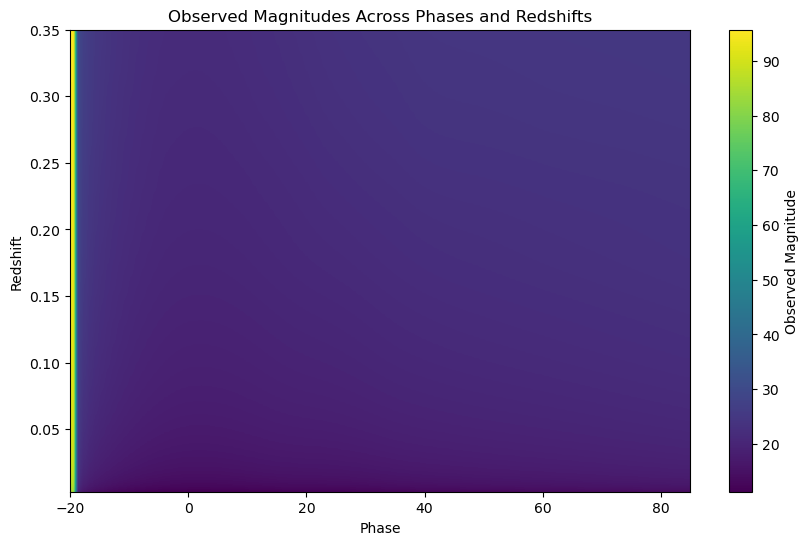

In [10]:
import numpy as np
import speclite.filters
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
import matplotlib.pyplot as plt


# Load scaled template data
scaled_template_file = '/home/jovyan/research/Current/scaled_hsiao_templates.dat'
scaled_template = np.genfromtxt(scaled_template_file, names='phase, wav, flux')

# Parameters
filter_choice = 'r'
z_min, z_max = 0.00293, 0.35
redshifts = np.linspace(z_min, z_max, 200)

# Compute observed magnitudes
phases, redshifts, obs_mags = compute_observed_magnitudes(scaled_template, filter_choice, redshifts)

# Save magnitudes to a data file
np.savetxt('observed_magnitudes.dat', obs_mags, header='Observed Magnitudes (rows=redshifts, columns=phases)')

# Plot the observed magnitudes as a 2D image
plt.figure(figsize=(10, 6))
plt.imshow(obs_mags, extent=[phases.min(), phases.max(), z_min, z_max], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Observed Magnitude')
plt.xlabel('Phase')
plt.ylabel('Redshift')
plt.title('Observed Magnitudes Across Phases and Redshifts')
plt.show()
#plt.savefig('observedMagVSredshi.png')

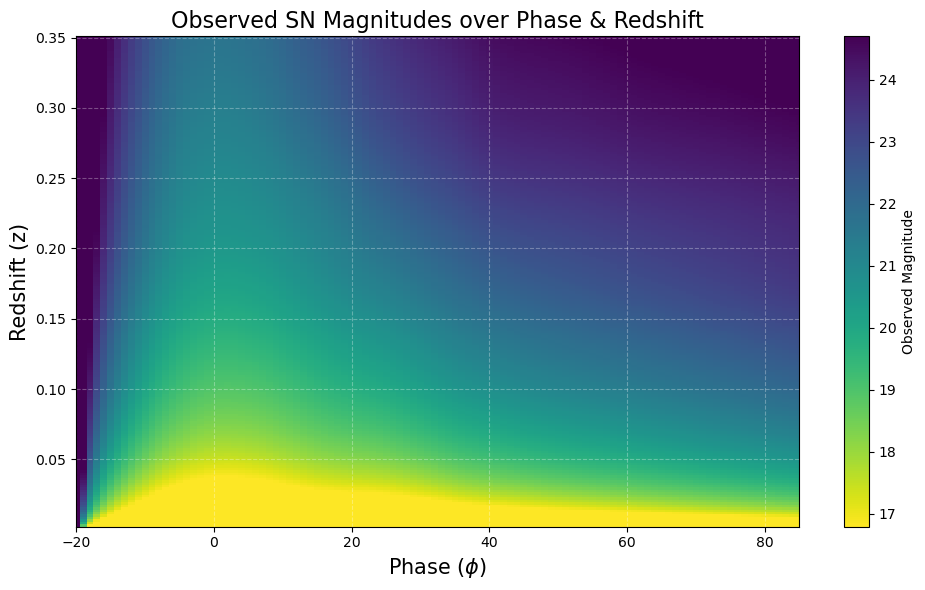

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# assume obs_mags.shape = (n_z, n_phase), 
# phases is length n_phase, redshifts length n_z:
redshifts = np.linspace(z_min, z_max, obs_mags.shape[0])
X, Y = np.meshgrid(phases, redshifts)

# 1) compute robust color limits:
vmin = np.percentile(obs_mags, 5)
vmax = np.percentile(obs_mags, 95)
norm = Normalize(vmin=vmin, vmax=vmax)

plt.figure(figsize=(10, 6))
mesh = plt.pcolormesh(
    X, Y, obs_mags,
    shading='auto',
    cmap='viridis_r',   # bright colors = bright mags
    norm=norm
)
cbar = plt.colorbar(mesh)
cbar.set_label('Observed Magnitude')

# 2) zoom in on the phase window of interest:
plt.xlim(-20, phases.max())   # drop the -20 day column
# if you still want to show it, you can mask obs_mags[:, phases < -15] instead

plt.xlabel(r'Phase ($\phi$)', fontsize=15)
plt.ylabel('Redshift (z)', fontsize=15)
plt.title('Observed SN Magnitudes over Phase & Redshift', fontsize=16)
plt.grid(color='white', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#plt.savefig('SIM_observed_magnitudes.png')

(25.0, 20.0)

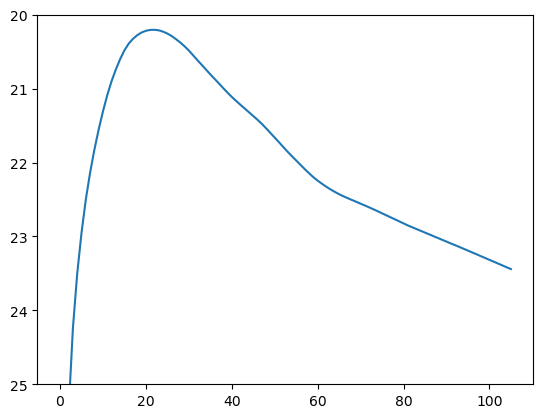

In [9]:
plt.plot(obs_mags[100])
plt.ylim(25,20)

(25.0, 20.0)

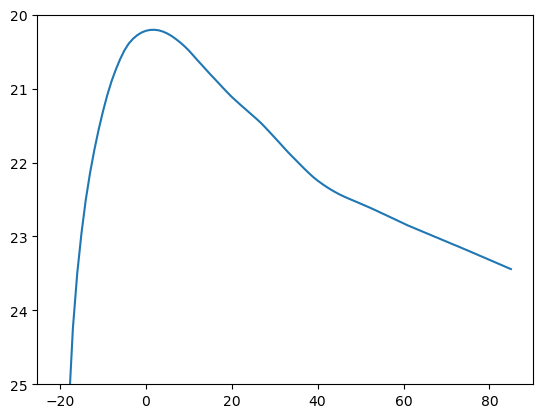

In [16]:
plt.plot(phases, obs_mags[100])
plt.ylim(25,20)

In [4]:
#from scipy.interpolate import RegularGridInterpolator
#magnitude_interpolator = RegularGridInterpolator((redshifts, phases), obs_mags)

# Simple function to get OBSERVED magnitude at given phase and redshift
#def get_magnitude(phase, redshift):
    #return magnitude_interpolator([[redshift, phase]])[0]


In [6]:
from scipy.interpolate import RegularGridInterpolator
magnitude_interpolator = RegularGridInterpolator(
    (redshifts, phases), obs_mags, bounds_error=False, fill_value=None)
def get_magnitude(phase, redshift):
    return magnitude_interpolator([[redshift, phase]])[0]

get_magnitude(0, 0.2)

20.49241381630652

In [7]:
#observed magnitude
get_magnitude(10, 0.0179)

15.50219774274818

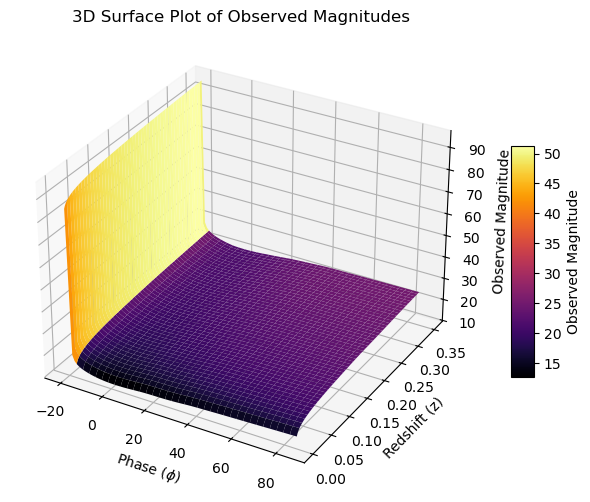

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection

# Create a meshgrid for the phases and redshifts
X, Y = np.meshgrid(phases, redshifts)

# Create the figure and 3D axis
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot a surface; you can adjust parameters like 'edgecolor' for different visual styles
surf = ax.plot_surface(X, Y, obs_mags, cmap='inferno', edgecolor='none')

# Add a color bar mapping the magnitude values
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Observed Magnitude')

# Set axis labels and title
ax.set_xlabel(r'Phase ($\phi$)')
ax.set_ylabel('Redshift (z)')
ax.set_zlabel('Observed Magnitude')
ax.set_title('3D Surface Plot of Observed Magnitudes')
plt.savefig('3Dplot.pdf')
plt.show()


THIS CODE IS THE NEWER COUNT DETECTIONS

In [9]:
import pandas as pd
import sys

def count_detections(jdmax, z, field_file, filter_choice):
    try:
        data = pd.read_csv(field_file)
    except Exception as e:
        print(f"Error reading file {field_file}: {e}")
        sys.exit(1)

    if 'obsjd' not in data.columns or 'maglimit' not in data.columns:
        print("The CSV file must contain 'obsjd' and 'maglimit' columns.")
        sys.exit(1)

    detection_count = 0

    # Loop over each observation epoch in the CSV file
    for index, row in data.iterrows():
        JD_obs = row['obsjd']
        limit = row['maglimit']
        
        # Calculate the observed phase (JD difference relative to maximum)
        phase_obs = JD_obs - jdmax
        # Convert to rest-frame phase (accounting for time dilation)
        phase_rest = phase_obs / (1 + z)
        
        # Compute the expected observed magnitude at this epoch using get_magnitude
        obs_mag = get_magnitude(phase_rest, z)
        
        # Count as detection if the SN is brighter than the limiting magnitude
        if obs_mag < limit:
            detection_count += 1

    return detection_count


In [10]:
field1241 = '/home/jovyan/research/Current/Field_Numbers/1241/observation.csv'
count_detections(2459286, 0.069, field1241, 'r')

0

In [13]:
field245 = '/home/jovyan/research/Current/Field_Numbers/245/observation.csv'
count_detections(2459133.0191346905, 0.00293, field245, 'r')

485